### **Summary of Project : Image Clustering with Deep Features**

**Objective:**
Cluster images into semantic groups without using labels, leveraging pretrained CNN embeddings.

**Steps Performed:**
1. **Dataset:** CIFAR-10 images (32x32).
2. **Preprocessing:** Images resized to 224x224 and preprocessed for ResNet50.
3. **Feature Extraction:** Used pretrained ResNet50 (without top) to extract 2048-dimensional embeddings.
4. **Dimensionality Reduction:** Applied PCA and t-SNE to reduce dimensions for 2D visualization.
5. **Clustering:** Applied K-Means (10 clusters).
6. **Visualization:**
   * t-SNE plot shows natural grouping of images.
   * Random image samples from each cluster to inspect cluster semantics.

**Key Insights:**
* Pretrained CNN features capture semantic content, allowing effective clustering even without labels.
* Clusters often group visually similar objects (e.g., animals, vehicles).
* Useful for **auto-tagging, image search, and gallery organization**.


### Step 1: Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf

### Step 2: Load CIFAR-10 Dataset


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X = X_train.astype('float32')


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 641s 4us/step


### Step 3: Preprocess Images


In [ ]:
subset = 1  # 100% of data if you have good hardware; else use 0.2 for 20%
n_samples = int(len(X_train) * subset)
X_train = X_train[:n_samples]
y_train = y_train[:n_samples]

batch_size = 1000
X_resized = []
for i in range(0, len(X_train), batch_size):
    batch = X_train[i:i+batch_size]
    batch_resized = tf.image.resize(batch, (224,224)).numpy()
    X_resized.append(batch_resized)
X_resized = np.vstack(X_resized)



### Step 4: Load Pretrained ResNet50


In [10]:
X_preprocessed = preprocess_input(X_resized)
# Load pretrained ResNet50 (exclude top layer)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print(base_model.summary())


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [11]:
#Extract features
features = base_model.predict(X_preprocessed, batch_size=64, verbose=1)
print("Shape of extracted features:", features.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step
Shape of extracted features: (2000, 2048)


### Step 5: Reduce Dimensionality for Visualization


In [12]:
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_pca)

### Step 6: Apply K-Means Clustering


In [13]:
n_clusters = 10  # CIFAR-10 has 10 classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

### Step 7: Visualize Clusters in 2D (t-SNE)


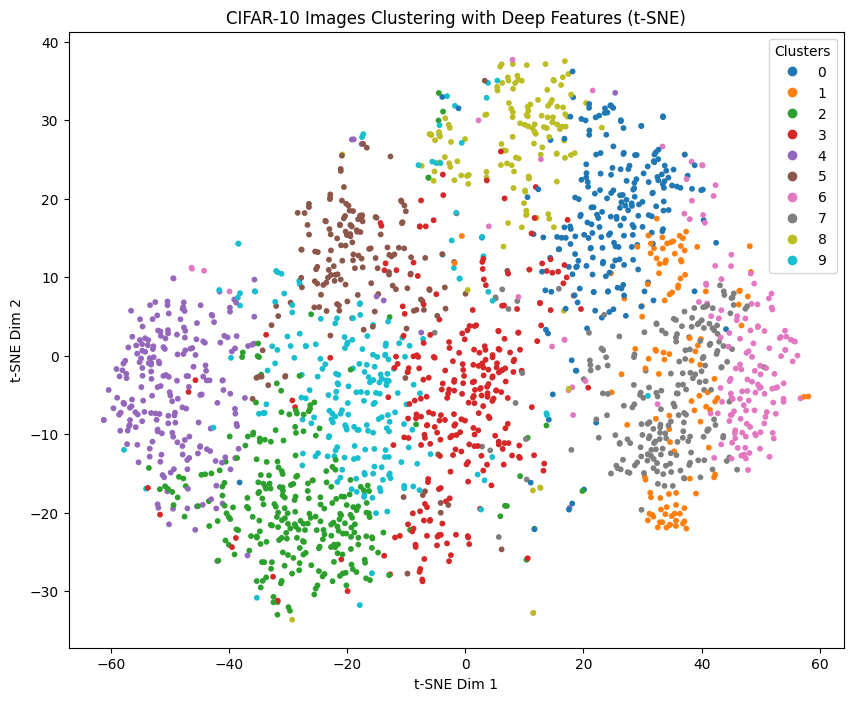

In [14]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("CIFAR-10 Images Clustering with Deep Features (t-SNE)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

### Step 8: Visualize Random Images per Cluster


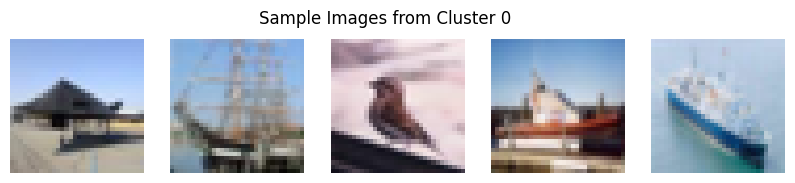

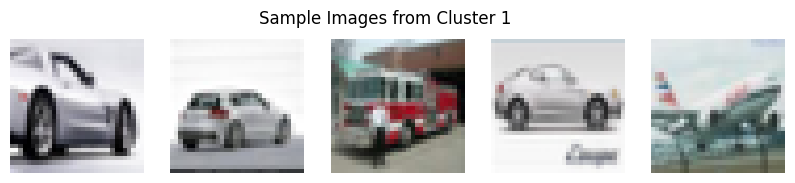

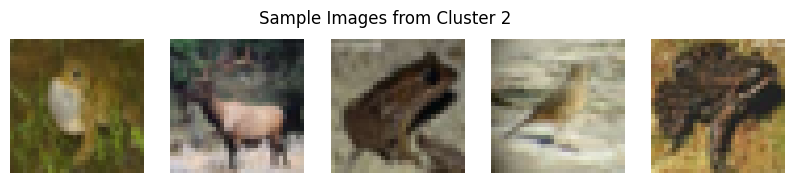

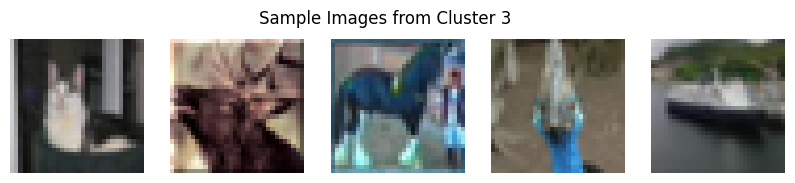

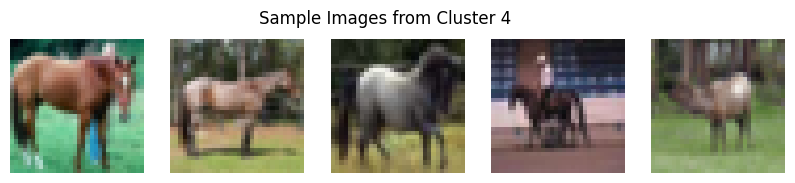

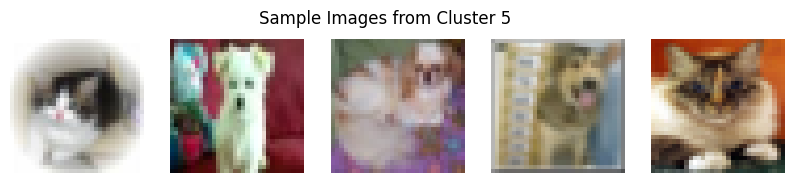

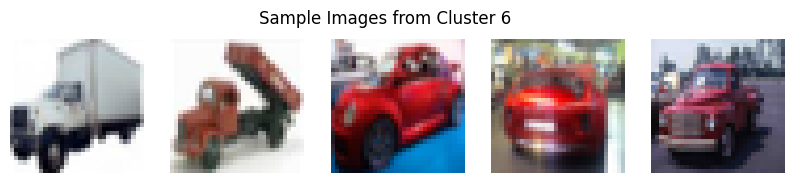

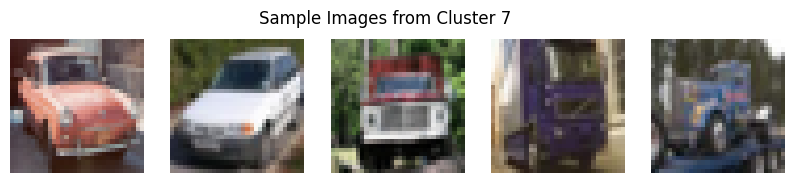

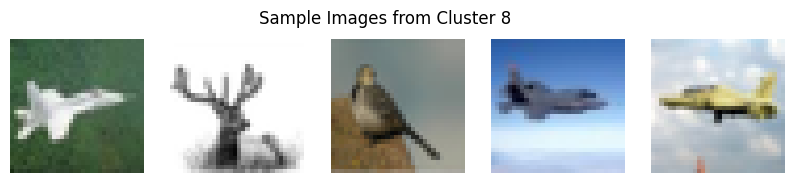

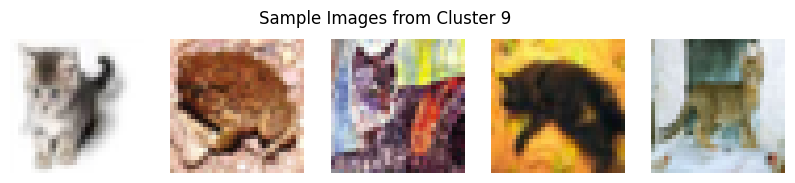

In [22]:
import random

for cluster in range(n_clusters):
    plt.figure(figsize=(10, 2))
    cluster_indices = np.where(cluster_labels == cluster)[0]
    sample_indices = random.sample(list(cluster_indices), 5)
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
    plt.suptitle(f"Sample Images from Cluster {cluster}")
    plt.show()

### **Workflow in this project**

1. **ResNet → Feature Extraction:** Converts images into embeddings.
2. **PCA → Dimensionality Reduction:** Makes embeddings manageable for clustering & visualization.
3. **t-SNE → Visualization:** Projects reduced embeddings to 2D for human interpretation.
4. **K-Means / DBSCAN → Clustering:** Assigns images to clusters based on similarity in the embedding space.

---

💡 **Analogy:**

* **ResNet** = “Look at the image and describe it in numbers.”
* **PCA** = “Compress the description to the essentials.”
* **t-SNE** = “Draw a map so that similar images appear near each other.”


### **1. ResNet (Pretrained CNN)**

* **Purpose:** Extract meaningful **high-level features** (embeddings) from images.
* CIFAR-10 images are small (32×32), and simple pixel values aren’t enough for clustering.
* Using **ResNet50 pretrained on ImageNet**, we get a **2048-dimensional feature vector** for each image that captures semantic content (like shapes, objects, textures).
* **Output:** Dense feature vectors for each image.

---

### **2. PCA (Principal Component Analysis)**

* **Purpose:** Reduce high-dimensional features (2048 from ResNet) to a lower dimension while retaining most variance.
* Helps:

  * Reduce computational load for clustering.
  * Remove noise and redundant dimensions.
  * Speed up algorithms like t-SNE or K-Means.
* Typical usage: Reduce from 2048 → 50–100 dimensions before t-SNE.

---

### **3. t-SNE (t-Distributed Stochastic Neighbor Embedding)**

* **Purpose:** Visualize high-dimensional data in **2D or 3D**.
* Maps high-dimensional vectors to 2D space such that **similar images cluster together**.
* t-SNE preserves **local structure** — points close in feature space remain close in 2D.
* **Output:** Scatter plot where clusters of similar images can be visually identified.
